# API development for download of Sentinel-2 and Landsat-8 data
### User defined mosaicing of harmonised products
_Robin Kohrs & Konstantin Schellenberg, February 2020, GEO 419_  
_Supervisor: John Truckenbrodt¹, Martin Habermeyer²_ <br>
<sub><sub>
¹ Friedrich-Schiller-University Jena, chair of remote sensing <br>
² Deutsches Luft- und Raumfahrtszentrum, earth observation center
</sub></sub>

## Tutorial
This is the extention for nasa_hls. We developed following new functions:

In order to make the program be more flexible, the goal of this extension is to
1. Download tiles by setting spatial (user defined verctor geometry) and temporal inqueries to the HLS server,
2. Mosaic the HDF4 formatted product per band and acquisition date.

As part of the module report will want to add the following post procession tasks: 
3. Calculate spectral indexes from the downloaded products.
4. Plot the results inline with `ipyleafet` and `folium` on a Open Street Map WMS service.

Tasks 1 and 2 are meant to work in accordance with the `nasa_hls` package and aims to lead to a pull request to the repository; 3 and 4 shall give an overview of to use the new utilities and the HLS product.

User guide to the HLS product:
https://hls.gsfc.nasa.gov/wp-content/uploads/2019/01/HLS.v1.4.UserGuide_draft_ver3.1.pdf

## <font color = "red"> Download HSL files with user input</font>

In [1]:
# change working directory 
import os
os.chdir("/home/robin/python_projects/nasa_hls")

In [2]:
import warnings
warnings.simplefilter("ignore")

In [48]:
%matplotlib inline

import nasa_hls
import sys
import pandas as pd
import os
from osgeo import gdal
gdal.UseExceptions()

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# and for later processing in the notebook

- For testing purpose, try downloading the kml file:

In [4]:
nasa_hls.download_kml()

UTM tiles already successfully downloaded to:
 /home/robin/.nasa_hls/.auxdata/utm.kml 



'/home/robin/.nasa_hls/.auxdata/utm.kml'

## <font color = "red">Make list with GeoDataFrames</font>

- This will serve as a conformation for the user
- It's a list of lists. Each inner list beeing the GeoDataFrames for the specified dates

In [5]:
ds = nasa_hls.make_tiles_dataset(shape="/home/robin/python_projects/data/nasa_hls/test_shape/dummy_region.dbf",
                                products=["S30"],
                                start_date="2018-12-25")


starting date: 2018-12-25
 
UTM tiles already successfully downloaded to:
 /home/robin/.nasa_hls/.auxdata/utm.kml 



  0%|          | 0/4 [00:00<?, ?it/s]


getting available datasets . . .


100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


In [6]:
# print the list of lists
print(ds, "\n\n")
print("The query starting at date '2018-12-25', resulted in {len} hls-prodcuts".format(len = len(ds)))


[    product   tile       date                                                url
65      S30  34JDN 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
200     S30  34JEN 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
268     S30  34JDP 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
403     S30  34JEP 2018-12-27  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...,     product   tile       date                                                url
201     S30  34JEN 2018-12-29  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...
404     S30  34JEP 2018-12-29  https://hls.gsfc.nasa.gov/data/v1.4/S30/2018/3...] 


The query starting at date '2018-12-25', resulted in 2 hls-prodcuts


- As one can see in the list, there are 4 scenes for the 27th of december and two products for the 29th.

***
## <font color = "red">Download Tiles</font>

- Taking this list, the data sources can be downloaded via `download_tiles`. 

- This function call `download_batch` and other methods internally in order to parse the right URLs for download.

- The path for the parameter `dir` needs to be adapted, as this is user-specific.

In [39]:
nasa_hls.download_tiles(dstdir=os.path.join("/home/robin/python_projects/data/nasa_hls/hdf_tiles"),
                        dataframes=ds)

100%|██████████| 2/2 [01:28<00:00, 44.44s/it]


- if you want to get an idea of one of the `hdf`-files you just downloaded

In [26]:
s = os.path.getsize("/home/robin/python_projects/data/nasa_hls/hdf_tiles/HLS.S30.T34JDN.2018361.v1.4.hdf")
print("The first downloaded 'hdf'-file is {0:.2f} MB in size on the disk".format(s/1e6))

The first downloaded 'hdf'-file is 244.24 MB in size on the disk


***
## <font color = "red">Mosaicing tiles</font>
- We will now mosaic all tiles for each day
- This is done by the function `make_mosaic`

In [29]:
# for simplicity make input and output file directories the same
# tiffs will end up in the same directory
# note the "/" at the end
src_dir = "/home/robin/python_projects/data/nasa_hls/hdf_tiles/"
out_dir = "/home/robin/python_projects/data/nasa_hls/hdf_tiles/"

In [31]:
#bands is set to None in order to use all bands
# as we downloaded Sentinel-Scenes, the argument `products` is given the paramter "S30"
nasa_hls.make_mosaic(srcdir=src_dir, dstdir=out_dir, bands = None, product="S30")

['361', '361', '363', '361', '361', '363']
361
363


***
## <font color = "red">Print Results</font>

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show

In [37]:
#filepath of one of the rasters (hdf-scenes)
fp = "/home/robin/python_projects/data/nasa_hls/hdf_tiles/361.tiff"
raster = rio.open(fp)

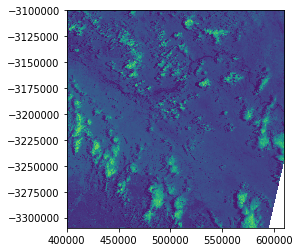

In [42]:
show(raster)

### get some metadata

In [76]:
# get the dimension of the raster by reading the first band
array = raster.read(1)
array.shape

(6994, 6994)

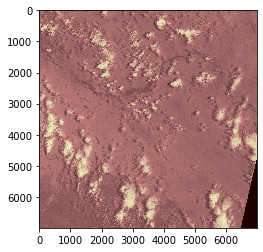

In [101]:
plt.imshow(array, cmap="pink")

In [79]:
# what are  datatype and the nodata-values in the final tiff
for i, dtype, nodataval in zip(raster.indexes, raster.dtypes, raster.nodatavals):
...     print(i, dtype, nodataval)

1 int16 -1000.0
2 int16 -1000.0
3 int16 -1000.0
4 int16 -1000.0
5 int16 -1000.0
6 int16 -1000.0
7 int16 -1000.0
8 int16 -1000.0
9 int16 -1000.0
10 int16 -1000.0
11 int16 -1000.0
12 int16 -1000.0


In [ ]:
vrt_path = "/home/robin/.nasa_hls/.auxdata/mosaic/days/361final.vrt"
vrt = rio.open(vrt_path)

In [99]:
# what are  datatype and the nodata-values in the vrt, that makes the final tiff above?
for i, dtype, nodataval in zip(vrt.indexes, vrt.dtypes, vrt.nodatavals):
    print(i, dtype, nodataval)

1 int16 -1000.0
2 int16 -1000.0
3 int16 -1000.0
4 int16 -1000.0
5 uint8 255.0
6 int16 -1000.0
7 int16 -1000.0
8 int16 -1000.0
9 int16 -1000.0
10 int16 -1000.0
11 int16 -1000.0
12 int16 -1000.0


- As one can see there is one band that is just of datatype `uint8` instad of being `int16


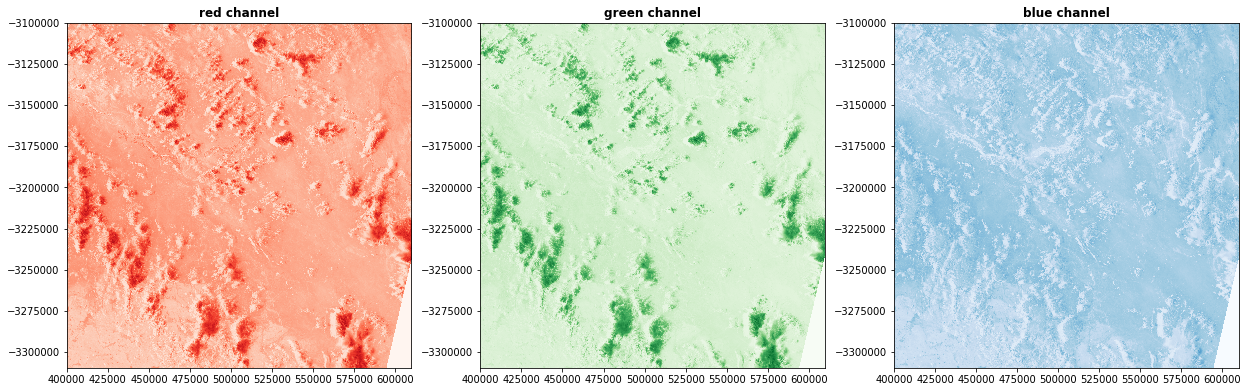

In [109]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((raster,4), ax = axr, cmap = "Reds", title = "red channel")
show((raster,3), ax = axg, cmap = "Greens", title = "green channel")
show((raster,2), ax = axb, cmap = "Blues", title = "blue channel" )


In [115]:
red = raster.read(4)
green = raster.read(3)
blue = raster.read(2)

In [121]:
# https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html 
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)


print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())


Normalized bands
0.0 - 1.0 mean: 0.3054635705129599
0.0 - 1.0 mean: 0.22204874167337776
0.0 - 1.0 mean: 0.31886845386844404


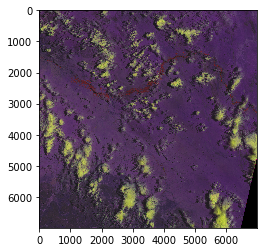

In [125]:
# stack bands together
rgb = np.dstack((redn, greenn, bluen))
plt.imshow(rgb)

## Calculate Indexes